<a href="https://colab.research.google.com/github/hpink97/loan_default_predictor/blob/main/03_ml_preprocessing_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preprocessing and Model training** 💻




### Load modules

In [2]:
#pip install bayesian-optimization
#pip install miceforest --no-cache-dir

In [49]:

import pandas as pd
import numpy as np 
import gc #free up memory
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf ##forest based imputation


import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score,precision_recall_curve,roc_curve, auc

from sklearn.preprocessing import RobustScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif, VarianceThreshold


## `Dataset` class for ML preprocessing

The `Dataset` class is designed to handle the preprocessing and splitting of a dataset for machine learning tasks. Here is a summary of its functionality:

1. Initialization: The class takes in a pandas DataFrame (`df`) representing the dataset and the target variable (`target`). It also accepts additional parameters like `is_test` to indicate if the dataset is a test set, `scaler` for scaling numeric columns, and `trained_cols` for indicating specific columns to be used in the final dataset.

2. Preprocessing: The `preprocess()` method performs preprocessing tasks on the dataset. It includes basic imputations for missing values, smart imputations using the `miceforest` package for remaining missing values, scaling of numeric columns, and label encoding for binary columns. It also performs one-hot encoding for categorical columns.

3. Splitting Data: The `split_data()` method splits the preprocessed dataset into training, evaluation, and testing sets. It takes parameters like `test_size` and `eval_size` to control the size of the test and evaluation sets, respectively. It prints information about the sizes and positive rates of each split.


In [4]:
class Dataset:
    def __init__(self, df, target,is_test=False, scaler=None, trained_cols = None):
      input_df = df.copy()
      self.is_test = is_test
      self.target = target
      self.X_train = None
      self.X_test = None
      self.X_eval = None
      self.y_eval = None
      self.y_train = None
      self.y_test = None
      self.preprocessed = False
      self.scaler = scaler
      self.label_encoders = None
      if self.is_test:
        self.y = None
        self.X = input_df
      else:
        self.y = input_df[self.target]
        self.X = input_df.drop(columns=[self.target])

    ##method to pre-process the df
    def preprocess(self, impute_dict=None, final_X_cols= None,
                   imputation_kernel_iterations = 4, imputation_kernel_ntrees = 50):
       # Basic imputations
      if impute_dict is not None:
        print(f'Performing basic imputations based on {len(impute_dict)} features supplied impute_dict')
        for col, strategy in impute_dict.items():
          if col not in self.X.columns:
            print(f"Skipping imputation for column '{col}' as it does not exist in the dataset.")
            continue
          if strategy == 'mean':
              self.X[col].fillna(self.X[col].mean(), inplace=True)
          elif strategy == 'median':
              self.X[col].fillna(self.X[col].median(), inplace=True)
          elif isinstance(strategy, str) and strategy.startswith('percentile_'):
              percentile = float(strategy.split('_')[1])
              self.X[col].fillna(self.X[col].quantile(percentile / 100), inplace=True)
          elif isinstance(strategy, (int, float)):
              self.X[col].fillna(strategy, inplace=True)
          else:
              raise ValueError(f"Invalid imputation strategy for column '{col}'.")
    #find numeric columns
      numeric_cols = self.X.select_dtypes(include=['int64', 'float64']).columns
      #print(numeric_cols)

      ## smart impuations - decision tree based method
      count_NA = self.X.isna().sum()
      remaining_NA_cols = count_NA[count_NA>0].shape[0]
      #print(remaining_NA_cols)
      if  remaining_NA_cols> 0:
        print(f'Performing decision-tree based imputations of {remaining_NA_cols} remaining features with missing data')
        kernal = mf.ImputationKernel(
            self.X[numeric_cols],
            random_state=42
            )
        # Run the MICE algorithm for 2 iterations
        kernal.mice(iterations=imputation_kernel_iterations,
                    n_estimators=imputation_kernel_ntrees)
        X_numeric_imputed = kernal.complete_data()
        self.X[numeric_cols] = X_numeric_imputed
      
      ##scale numeric cols
      print('Scaling numeric data')
      if self.scaler is None:
        self.scaler = StandardScaler()
        self.X[numeric_cols] = self.scaler.fit_transform(self.X[numeric_cols])
      else:
        scaler_trained_features = self.scaler.feature_names_in_
        missing_cols = set(scaler_trained_features) - set(self.X.columns)
        if len(missing_cols) >0:
          print(f"{len(missing_cols)} variables that scaler was originally trained on are missing - will replace with zeros")
          for col in missing_cols:
            self.X[col] = 0
        self.X[scaler_trained_features] = self.scaler.transform(self.X[scaler_trained_features])
  
      
      # Perform label encoding for binary columns
      print('One-hot-encoding categorical vars')
      binary_cols = [col for col in self.X.columns if self.X[col].nunique() == 2]
      self.label_encoders = {}

      # Label encode binary columns
      for col in binary_cols:
          label_encoder = LabelEncoder()
          self.X[col] = label_encoder.fit_transform(self.X[col])
          # Store the label encoder for later use
          self.label_encoders[col] = label_encoder
      
      # Perform one-hot encoding for categorical columns
      categorical_cols = [col for col in self.X.columns if self.X[col].dtype == 'object' and col not in binary_cols]
      self.X = pd.get_dummies(self.X, columns=categorical_cols)

      if final_X_cols is not None:
        print('splicing dataset to include only final_X_cols columns')
        missing_cols = set(final_X_cols) - set(self.X.columns)
        for col in missing_cols:
          self.X[col] = 0
        self.X = self.X[final_X_cols]

      self.preprocessed = True
    

    def split_data(self, test_size=0.15,eval_size = 0.15, random_state=42):
        if not self.preprocessed:
          raise RuntimeError("Data has not been preprocessed. Please run the preprocess method.")
        
        if self.is_test:
          raise RuntimeError("Cannot run split_data() method on a test set")

        
        X_train_eval, self.X_test, y_train_eval, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

        eval_split_size = eval_size/(1-test_size)
        self.X_train, self.X_eval, self.y_train, self.y_eval = train_test_split(
            X_train_eval, y_train_eval, test_size=eval_split_size, random_state=random_state)

        print(f"{self.X_train.shape[0]} training samples, {self.X_eval.shape[0]} evaluation samples and {self.X_test.shape[0]} testing samples")
        print(f"{self.y_train.sum()} ({self.y_train.mean()*100:.3f}%) positives in training set")
        print(f"{self.y_eval.sum()} ({self.y_eval.mean()*100:.3f}%) positives in evaluation set")
        print(f"{self.y_test.sum()} ({self.y_test.mean()*100:.3f})% positives in testing set")


## `Model` Class for training xgboost models

The model class provides a streamlined workflow for feature selection, model training, and evaluation of xgboost models.

Here is a summary of the key features and methods of the Model class:



1.   **Initialisation**: The class is initialized with the necessary input data using the `Dataset` class, including the training and test sets (`X_train`, `X_test`) and their corresponding target variables (`y_train`, `y_test`).
2.   **Feature Selection**: The `select_features()` method allows you to perform feature selection using the `sklearn.feature_selection.SelectKBest` algorithm. It selects the top num_features based on mutual information classification scores.
3. **Model Training**: The `train_model()` method trains an XGBoost classifier using the specified xgboost_params. It uses the training data and evaluates the model's performance on the evaluation set (`X_eval`, `y_eval`). Early stopping is implemented to prevent overfitting.
4. **Model Evaluation**: The `evaluate_model()` method calculates and prints various evaluation metrics, including F1 score, accuracy, precision, recall, specificity, ROC AUC score, and balanced accuracy. It also selects the optimal threshold for determining binary predictions based on the F1 score.
5. **Performance Visualisation**: The class provides several plotting methods to visualise model performance, including `plot_roc_auc()` to visualize the ROC curve and calculate the AUC score, `plot_predictions()` to plot the predicted probabilities against the true labels, and `plot_feature_importance()` to display the feature importances using a bar plot.

In [50]:
class Model:
    ##initialise the model class - taking instance of `Dataset` class an input
    def __init__(self, dataset_class):
        if not isinstance(dataset_class.X_train, pd.DataFrame) or not isinstance(dataset_class.X_test, pd.DataFrame):
            raise TypeError("X_train and X_test must be pandas DataFrames")
        if not isinstance(dataset_class.y_train, pd.Series) or not isinstance(dataset_class.y_test, pd.Series):
            raise TypeError("y_train and y_test must be pandas Series")
        ## take train-eval-test split datasets from input
        self.X_train = dataset_class.X_train
        self.X_eval = dataset_class.X_eval
        self.X_test = dataset_class.X_test
        self.y_train = dataset_class.y_train
        self.y_eval = dataset_class.y_eval
        self.y_test = dataset_class.y_test
        ##set up attributes to be used later
        self.y_pred = None
        self.xgboost_params = None
        self.num_features = None
        self.feature_names = dataset_class.X_train.columns
        self.selected_features = None
        self.model = None
        self.is_model_trained = False


    ##define method to select best n features in dataset
    ##basically a wrapper for SelectKBest from sklearn

    def select_features(self, num_features):
        if not isinstance(num_features, (int, float)):
            raise TypeError("num_features must be an int or float")

        # Remove constant features using VarianceThreshold
        constant_filter = VarianceThreshold(threshold=0)
        self.X_train = constant_filter.fit_transform(self.X_train)
        self.X_eval = constant_filter.transform(self.X_eval)
        self.X_test = constant_filter.transform(self.X_test)

        # Round num_features to the nearest integer
        num_features = max(min(round(num_features), self.X_train.shape[1]), 2)

        # Perform feature selection
        selector = SelectKBest(score_func=f_classif, k=num_features)
        selector.fit(self.X_train, self.y_train)
        mask = selector.get_support()

        # Get selected feature indices
        selected_indices = np.where(mask)[0]
        self.selected_features = self.feature_names[selected_indices]

        # Update X datasets with selected features
        self.X_train = self.X_train[:, selected_indices]
        self.X_eval = self.X_eval[:, selected_indices]
        self.X_test = self.X_test[:, selected_indices]

    

    ## defne method to train the classifier
    def train_model(self, 
                    xgboost_params,
                    print_training_evaluation=False ,
                    num_boost_round=700,
                    early_stopping_rounds=20):
      self.xgboost_params = xgboost_params
      ##create xgb Matrix objects for datasets
      dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
      ##
      deval = xgb.DMatrix(self.X_eval, label = self.y_eval)
      self.model = xgb.train(self.xgboost_params,
                             dtrain = dtrain, 
                             evals=[(deval, 'eval')],
                             verbose_eval=print_training_evaluation,
                             num_boost_round=num_boost_round,
                             early_stopping_rounds=early_stopping_rounds )
      print('Model training completed')
      self.is_model_trained = True

    def roc_auc(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)

      roc_auc = roc_auc_score(self.y_test, self.y_pred)

      return roc_auc
    
    def evaluate_model(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
      ##select best threshold for determining 
      best_threshold = 0
      best_f1 = 0
      
      # Iterate over different threshold values
      for threshold in np.arange(0.1, 1.0, 0.05):
          y_pred_binary = (self.y_pred >= threshold).astype(int)
          f1 = f1_score(self.y_test, y_pred_binary)

          if f1 > best_f1:
              best_f1 = f1
              best_threshold = threshold
      
      # Convert predicted probabilities to binary predictions based on the best threshold
      y_pred_binary = (self.y_pred >= best_threshold).astype(int)
      
      # Calculate accuracy metrics
      accuracy = accuracy_score(self.y_test, y_pred_binary)
      precision = precision_score(self.y_test, y_pred_binary)
      recall = recall_score(self.y_test, y_pred_binary)
      specificity = recall_score(self.y_test, y_pred_binary, pos_label=0)
      roc_auc = self.roc_auc()
      balanced_accuracy = balanced_accuracy_score(self.y_test, y_pred_binary)
      
      # Print the metrics
      print(f"Optimal Threshold: {best_threshold:.3f}")
      print(f"F1 Score: {best_f1:.3f}")
      print(f"Accuracy: {accuracy:.3f}")
      print(f"Precision: {precision:.3f}")
      print(f"Recall (Sensitivity): {recall:.3f}")
      print(f"Specificity (True Negative Rate): {specificity:.3f}")
      print(f"ROC AUC Score: {roc_auc:.3f}")
      print(f"Balanced Accuracy: {balanced_accuracy:.3f}")

    
    def plot_roc_auc(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
      
      fpr, tpr, _ = roc_curve(self.y_test, self.y_pred)
      roc_auc = self.roc_auc()
      plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()
    def plot_predictions(self):
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
            
      sns.regplot(x=self.y_pred, y=self.y_test, scatter_kws={'alpha': 0.3})
      plt.xlabel('Predicted Probabilities')
      plt.ylabel('True Labels')
      plt.title('Predicted Probabilities vs. True Labels')
      plt.show()
    
    
    def plot_feature_importance(self, n_features =None):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before feature importances can be evaluated")

      feature_importances = self.model.get_score(importance_type='weight')
      if n_features is None:
        n_features = len(feature_importances)

      sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

      # Extract feature names and importance scores
      features = [x[0] for x in sorted_feature_importances]
      importances = [x[1] for x in sorted_feature_importances]

      # Create a bar plot of sorted feature importances
      plt.figure(figsize=(8, 9.5))
      plt.barh(features[0:(n_features-1)][::-1], 
               importances[0:(n_features-1)][::-1])
      plt.xlabel('Importance')
      plt.ylabel('Features')
      plt.title(f'Top {n_features} Features')
      plt.tight_layout()
      plt.show()

    def predict_prob(self, new_dataset, threshold = None): 
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before new predictions can be made")
      if isinstance(new_dataset, pd.DataFrame):
        data = new_dataset[self.X_train.columns]
      elif isinstance(new_dataset, Dataset): 
        data = new_dataset.X[self.X_train.columns]
      
      dtest = xgb.DMatrix(data)
      y = self.model.predict(dtest)
      if threshold is None:
        return y
      elif isinstance(threshold, float):
        ##ensure threshold is between 0 and 1
        threshold = max(min(float(threshold), 1), 0)
        print(f'obtaining model class using supplied threshold:{threshold}')
        ##convert to class
        y_class = (y >= threshold).astype(int)
        return y_class
      else:
        print('threshold must be supplied as a float between 0 and 1 - returning probabilities instead!')
        return y
      
      



## Read in training dataset



In [6]:
df= pd.read_csv('all_data_merged.csv')
df.shape

(307511, 200)

Load previous results from single feature logistic regression deviance reduction % (performed in `02_credit_risk_eda_feature_selection.Rmd`). 

$$
Deviance Reduction \% = 100*\left(\frac{{\text{{null deviance}} - \text{{residual deviance}}}}{{\text{{null deviance}}}}\right)
$$


We will use this as a metric of feature importance. In order to save compute `less_relavent_features` can be imputed using basic methods such as median. Whereas `important_features` with missing data will be imputed by training decision trees to predict missing values. 

In [7]:
lr_results = pd.read_csv('logistic_regression_results.csv')
important_features = lr_results.feature[lr_results.deviance_reduction >0.1]
less_relavent_features = lr_results.feature[lr_results.deviance_reduction <= 0.1]

In [8]:
impute_dict = {feature: 'median' for feature in less_relavent_features}
impute_dict['own_car_age'] = 'percentile_95'

Create a `Dataset` class instance, and use the `.preprocess()` method to perform data pre-processing steps. Supply `impute_dict` to state which columns shown undergo **basic imputations**. Reamianing columns will undergo **smart imputations** using `miceforest.ImputationKernel()` decision tree based imputation method.

In [9]:
data = Dataset(df, target = 'target')
data.preprocess(impute_dict=impute_dict,
                imputation_kernel_iterations=2, imputation_kernel_ntrees=45)

Performing basic imputations based on 82 features supplied impute_dict
Performing decision-tree based imputations of 28 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars


Use `Dataset.split_data()` method to perform train-evaluation-test split on the dataset

In [10]:
data.split_data(test_size=0.175, eval_size=0.175)
data.X_train.head(3)

199881 training samples, 53815 evaluation samples and 53815 testing samples
16177 (8.093%) positives in training set
4311 (8.011%) positives in evaluation set
4337 (8.059)% positives in testing set


,sk_id_curr,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_other,emergencystate_mode_No,emergencystate_mode_Yes,emergencystate_mode_other,age_group_30-45,age_group_45-60,age_group_60+,age_group_under 30
115761,-0.427401,0,0,1,-0.577538,0.142129,-0.034848,-0.160244,0.126790,0.714822,...,1,0,0,1,0,0,0,0,1,0
143870,-0.110492,0,0,1,-0.577538,-0.332309,-1.197610,-1.398149,-1.140120,0.399377,...,0,0,1,0,0,1,0,1,0,0
305637,1.711562,0,1,1,-0.577538,-0.142533,1.149279,0.280335,1.052609,0.127023,...,0,0,0,1,0,0,0,1,0,0


## Train a model containing all features

Use the `Model` class to train an XGboost classifier. We can feed the `Dataset` object directly into `Model`, so train-eval-test splits can be extracted. Then use `select_features` to perform feature selection.

In [11]:
model_full = Model(dataset_class=data)


In [12]:
xgb_params = {
    'max_depth': 4,
    'learning_rate': 0.02,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 12,
    'subsample':0.5,
    'colsample_bytree':0.5,
    'colsample_bynode': 0.8,
    'min_child_weight':1.5    
}

model_full.train_model(xgb_params,num_boost_round=1500, early_stopping_rounds=25, print_training_evaluation=False)


Model training completed


In [13]:
model_full.model.best_iteration

771

In [14]:
best_eval_score = model_full.model.best_score
print(f"best ROC-AUC score on evaluation set = {best_eval_score:.3f}")


best ROC-AUC score on evaluation set = 0.777


In [15]:
model_full.evaluate_model()

Optimal Threshold: 0.650
F1 Score: 0.325
Accuracy: 0.843
Precision: 0.249
Recall (Sensitivity): 0.470
Specificity (True Negative Rate): 0.876
ROC AUC Score: 0.775
Balanced Accuracy: 0.673


### Take a look at feature importances - what is the model using to make predictions?

`ext_source_1|2|3` are the top three features these normalised datapoints supplied in the dataset frm unknown external sources

`age`, `yrs_employed` and `perc_adult_life_employed` are all high-importance features

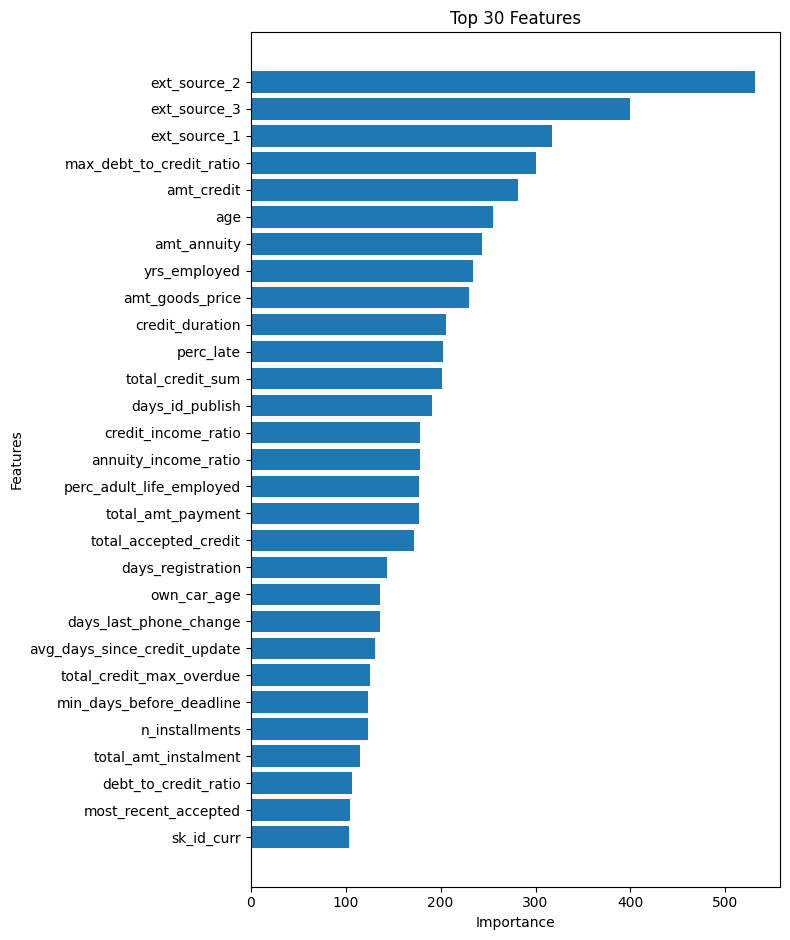

In [16]:
model_full.plot_feature_importance(n_features= 30)

## Make predictions based on our test set

1.  Load in our test data using `pd.read_csv()`
2.  Initilise a `Dataset` class object for our test data, reusing the original scaler from training set (which can be accessed as an attribute `data.scaler`)
3. Use the `Dataset.preprocess()` method to impute missing values, scale the dataset (with original scaler), encode categorical values. We also use the `final_X_cols=model_full.X_train.columns` argument to ensure the output X dataframe has the same features as model was trained on. 
4. Use the `Model.predict_proba()` method to predict defaulting probability. 


We can then submit our test results to Kaggle, and we achieve an ROC-AUC of 0.759
---

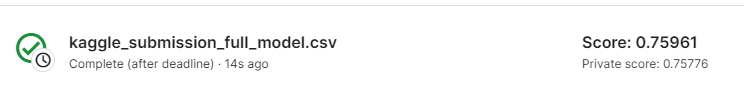




In [18]:
##import test dataset 
test = pd.read_csv('all_TEST_data_merged.csv')

test_data = Dataset(test, target = None, is_test=True,scaler = data.scaler)
test_data.preprocess(impute_dict=impute_dict,
                     final_X_cols=model_full.X_train.columns,
                     imputation_kernel_iterations=2,
                     imputation_kernel_ntrees=50)

test_y_pred = model_full.predict_prob(new_dataset=test_data)
test['target']=test_y_pred
test['sk_id_curr'] = test['sk_id_curr'].astype('int')
kaggle_submission = test[['sk_id_curr','target']]
kaggle_submission.to_csv('kaggle_submission_full_model.csv', index=False)
kaggle_submission.head(10)

Performing basic imputations based on 82 features supplied impute_dict
Performing decision-tree based imputations of 26 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars
splicing dataset to include only final_X_cols columns


,sk_id_curr,target
0,100001,0.408966
1,100005,0.602884
2,100013,0.114497
3,100028,0.372963
4,100038,0.682876
5,100042,0.256302
6,100057,0.173328
7,100065,0.251704
8,100066,0.125341
9,100067,0.401039


## Perform `BayesianOptimisation` of hyperparams

Set up an `objective_function()` to optimisie our model using `BayesianOptimisation()`. Limit model training to `num_boost_round=250` so increased speed, allowing more iterations of bayesian search. We can then retrain a model with the best hyperparamters for more boosting rounds.  

By using `optimizer.probe()` was can tell the optimisation to search to begin at our original hyperparamaters used in `model_full`.

In [19]:
def objective_function(learning_rate,max_depth, 
                       scale_pos_weight, subsample,
                       colsample_bytree,colsample_bynode,
                       min_child_weight):

  xgb_params = {
    'max_depth': int(max_depth),
    'learning_rate': learning_rate,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'subsample':subsample,
    'colsample_bynode':colsample_bynode,
    'min_child_weight': min_child_weight,
    'colsample_bytree':colsample_bytree,
    'eval_metric':'auc'
}

  model = Model(dataset_class=data)
  #model.select_features()
  model.train_model(xgb_params,
                          num_boost_round=250,
                          early_stopping_rounds=5,
                          print_training_evaluation=False)

  # Make predictions and calculate evaluation metric (e.g., ROC-AUC)
  roc_auc = model.model.best_score
  
  # Return ROC-AUC value for BayesianOptimization to maximise
  return roc_auc
        
# Define the hyperparameter search space for Bayesian optimization
pbounds = {
    'learning_rate': (0.0001, 0.4),
    'max_depth': (3, 20),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'colsample_bynode':(0.3,1),
    'min_child_weight': (0, 5),
    'scale_pos_weight': (6,20)
    #'num_features': (25,data.X_train.shape[1])
}


# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)


In [20]:
optimizer.probe({param: xgb_params[param] for param in pbounds.keys()})
optimizer.maximize(init_points=10, 
                   n_iter=25)

|   iter    |  target   | colsam... | colsam... | learni... | max_depth | min_ch... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------
Model training completed
| 1         | 0.7494    | 0.8       | 0.5       | 0.02      | 4.0       | 1.5       | 12.0      | 0.5       |
Model training completed
| 2         | 0.689     | 0.5622    | 0.9655    | 0.2928    | 13.18     | 0.7801    | 8.184     | 0.3407    |
Model training completed
| 3         | 0.7644    | 0.9063    | 0.7208    | 0.2833    | 3.35      | 4.85      | 17.65     | 0.4486    |
Model training completed
| 4         | 0.7442    | 0.4273    | 0.4284    | 0.1218    | 11.92     | 2.16      | 10.08     | 0.7283    |
Model training completed
| 5         | 0.7504    | 0.3976    | 0.5045    | 0.1466    | 10.75     | 3.926     | 8.795     | 0.66      |
Model training completed
| 6         | 0.7667    | 0.7147    | 0.3325    | 0.2431    | 5.899     | 0.3253

In [21]:
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['objective'] ='binary:logistic'
best_params['eval_metric']='auc'

model = Model(dataset_class=data)
model.train_model(best_params,
                        num_boost_round=1250,
                        early_stopping_rounds=50,
                        print_training_evaluation=True)

[0]	eval-auc:0.63587
[1]	eval-auc:0.65609
[2]	eval-auc:0.68084
[3]	eval-auc:0.69678
[4]	eval-auc:0.71139
[5]	eval-auc:0.73093
[6]	eval-auc:0.73232
[7]	eval-auc:0.73050
[8]	eval-auc:0.73255
[9]	eval-auc:0.73340
[10]	eval-auc:0.74241
[11]	eval-auc:0.74423
[12]	eval-auc:0.74629
[13]	eval-auc:0.74816
[14]	eval-auc:0.75058
[15]	eval-auc:0.75143
[16]	eval-auc:0.75237
[17]	eval-auc:0.75552
[18]	eval-auc:0.75630
[19]	eval-auc:0.75829
[20]	eval-auc:0.75897
[21]	eval-auc:0.75915
[22]	eval-auc:0.75972
[23]	eval-auc:0.76053
[24]	eval-auc:0.76039
[25]	eval-auc:0.76056
[26]	eval-auc:0.76088
[27]	eval-auc:0.76138
[28]	eval-auc:0.76186
[29]	eval-auc:0.76221
[30]	eval-auc:0.76296
[31]	eval-auc:0.76375
[32]	eval-auc:0.76400
[33]	eval-auc:0.76427
[34]	eval-auc:0.76509
[35]	eval-auc:0.76585
[36]	eval-auc:0.76624
[37]	eval-auc:0.76630
[38]	eval-auc:0.76646
[39]	eval-auc:0.76645
[40]	eval-auc:0.76658
[41]	eval-auc:0.76661
[42]	eval-auc:0.76693
[43]	eval-auc:0.76715
[44]	eval-auc:0.76726
[45]	eval-auc:0.7677

In [22]:
model.evaluate_model()

Optimal Threshold: 0.600
F1 Score: 0.322
Accuracy: 0.867
Precision: 0.274
Recall (Sensitivity): 0.392
Specificity (True Negative Rate): 0.909
ROC AUC Score: 0.773
Balanced Accuracy: 0.650


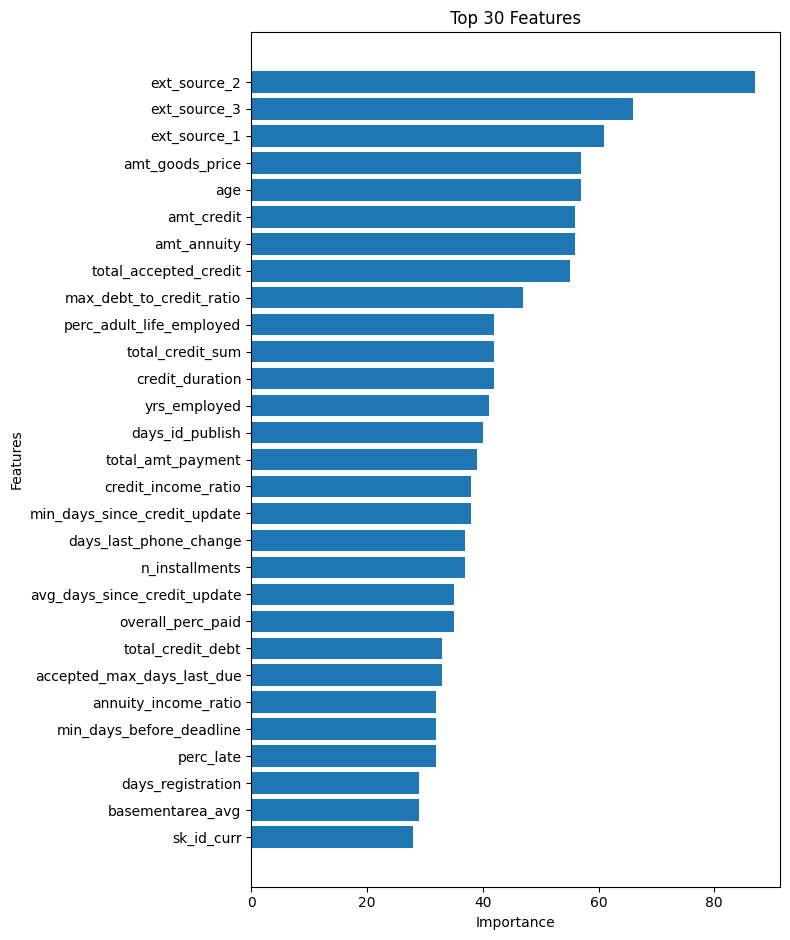

In [23]:
model.plot_feature_importance(n_features=30)

## Train a simplified model with `ext_source`

In [40]:
cols_2_keep = [x for x in df.columns if not x.startswith('ext_source|flag_document')]
cols_2_keep

['sk_id_curr',
 'target',
 'name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'cnt_children',
 'amt_income_total',
 'amt_credit',
 'amt_annuity',
 'amt_goods_price',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'region_population_relative',
 'days_registration',
 'days_id_publish',
 'own_car_age',
 'flag_mobil',
 'flag_emp_phone',
 'flag_work_phone',
 'flag_cont_mobile',
 'flag_phone',
 'flag_email',
 'occupation_type',
 'cnt_fam_members',
 'region_rating_client',
 'region_rating_client_w_city',
 'weekday_appr_process_start',
 'hour_appr_process_start',
 'reg_region_not_live_region',
 'reg_region_not_work_region',
 'live_region_not_work_region',
 'reg_city_not_live_city',
 'reg_city_not_work_city',
 'live_city_not_work_city',
 'organization_type',
 'ext_source_1',
 'ext_source_2',
 'ext_source_3',
 'apartments_avg',
 'basementarea_avg',
 'years_beginexpluatation_avg',
 'years_build_avg',
 'common

In [54]:
no_ext_source = df.copy()[cols_2_keep]
data2 = Dataset(no_ext_source, target = 'target')
data2.preprocess(impute_dict=impute_dict,
                imputation_kernel_iterations=3, imputation_kernel_ntrees=50)

Performing basic imputations based on 82 features supplied impute_dict
Performing decision-tree based imputations of 28 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars


In [55]:
data2.split_data()

215257 training samples, 46127 evaluation samples and 46127 testing samples
17250 (8.014%) positives in training set
3858 (8.364%) positives in evaluation set
3717 (8.058)% positives in testing set


In [56]:
def objective_function_with_feat_select(learning_rate,max_depth, 
                       scale_pos_weight, subsample,
                       colsample_bytree,colsample_bynode,
                       min_child_weight,num_features):

  xgb_params = {
    'max_depth': int(max_depth),
    'learning_rate': learning_rate,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'subsample':subsample,
    'colsample_bynode':colsample_bynode,
    'min_child_weight': min_child_weight,
    'colsample_bytree':colsample_bytree,
    'eval_metric':'auc'
}

  model = Model(dataset_class=data2)
  ##add feature selection step
  model.select_features(num_features)
  model.train_model(xgb_params,
                          num_boost_round=250,
                          early_stopping_rounds=5,
                          print_training_evaluation=False)

  # Make predictions and calculate evaluation metric (e.g., ROC-AUC)
  roc_auc = model.model.best_score
  
  # Return ROC-AUC value for BayesianOptimization to maximise
  return roc_auc
        
# Define the hyperparameter search space for Bayesian optimization
pbounds = {
    'learning_rate': (0.0001, 0.4),
    'max_depth': (3, 20),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'colsample_bynode':(0.3,1),
    'min_child_weight': (0, 5),
    'scale_pos_weight': (6,20),
    'num_features': (10,150)
}


# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function_with_feat_select,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)




In [ ]:

best_params['num_features'] = 75
optimizer.probe({param: best_params[param] for param in pbounds.keys()})
optimizer.maximize(init_points=10, 
                   n_iter=25)

|   iter    |  target   | colsam... | colsam... | learni... | max_depth | min_ch... | num_fe... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Model training completed
| 1         | 0.7647    | 0.3927    | 0.3392    | 0.1862    | 4.0       | 4.048     | 75.0      | 7.832     | 0.9524    |
Model training completed
| 2         | 0.7033    | 0.5622    | 0.9655    | 0.2928    | 13.18     | 0.7801    | 31.84     | 6.813     | 0.9063    |
Model training completed
| 3         | 0.7455    | 0.7208    | 0.7957    | 0.008332  | 19.49     | 4.162     | 39.73     | 8.546     | 0.4284    |
Model training completed
| 4         | 0.7477    | 0.513     | 0.6673    | 0.1728    | 7.951     | 3.059     | 29.53     | 10.09     | 0.5565    |
Model training completed
| 5         | 0.7272    | 0.6192    | 0.8496    | 0.07995   | 11.74     | 2.962     | 16.5      | 14.51     | 0.4194    |
Model training comple